In [1]:
#To get detailed description if get CUDA error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity

import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

Global seed set to 0
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [4]:
st = time.time()

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [6]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2'] 


trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [7]:
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'
gdown.download(url, output, quiet=False)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd 



In [8]:
adata_all = sc.read('pancreas.h5ad')

In [9]:
adata = adata_all.raw.to_adata()
# adata = sc.pp.subsample(adata, fraction=None, n_obs=1000, random_state=0, copy=True)
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_conditions = source_adata.obs[condition_key].unique().tolist()
source_conditions

['Pancreas inDrop', 'Pancreas CelSeq', 'Pancreas Fluidigm C1']

In [10]:
source_adata.obs

,batch,study,cell_type,size_factors
index,,,,
0-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,1.307300e+04
1-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,1.722700e+04
2-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,7.844000e+03
3-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,1.096600e+04
4-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,8.815000e+03
...,...,...,...,...
633-1-0,0,Pancreas Fluidigm C1,Pancreas Alpha,9.318808e+05
634-1-0,0,Pancreas Fluidigm C1,Pancreas Beta,1.282420e+06
635-1-0,0,Pancreas Fluidigm C1,Pancreas Beta,1.378794e+06


In [11]:
target_adata.obs

,batch,study,cell_type,size_factors
index,,,,
0-1-0-0-0,0,Pancreas CelSeq2,Pancreas Alpha,15213.940430
2-1-0-0-0,0,Pancreas CelSeq2,Pancreas Delta,11714.072266
3-1-0-0-0,0,Pancreas CelSeq2,Pancreas Beta,26895.630859
4-1-0-0-0,0,Pancreas CelSeq2,Pancreas Ductal,12899.861328
5-1-0-0-0,0,Pancreas CelSeq2,Pancreas Ductal,17666.962891
...,...,...,...,...
2984-1,1,Pancreas SS2,Pancreas Gamma,221018.000000
2985-1,1,Pancreas SS2,Pancreas Alpha,161140.000000
2986-1,1,Pancreas SS2,Pancreas Delta,144527.000000


In [12]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 1000 128 3
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 3
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [13]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    learning_approach='Surgery',
)

Surgery is happening!
 |███-----------------| 17.8%  - val_loss: 593.7843661838 - val_recon_loss: 580.4454616970 - val_kl_loss: 17.0051417881 - val_mmd_loss: 5.8566508823
ADJUSTED LR
 |████----------------| 23.6%  - val_loss: 536.9178127713 - val_recon_loss: 523.3337707520 - val_kl_loss: 15.4965258704 - val_mmd_loss: 4.5185629527
ADJUSTED LR
 |█████---------------| 25.0%  - val_loss: 551.9200981988 - val_recon_loss: 537.7015380859 - val_kl_loss: 15.4499934514 - val_mmd_loss: 4.6395696004
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 103


In [14]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

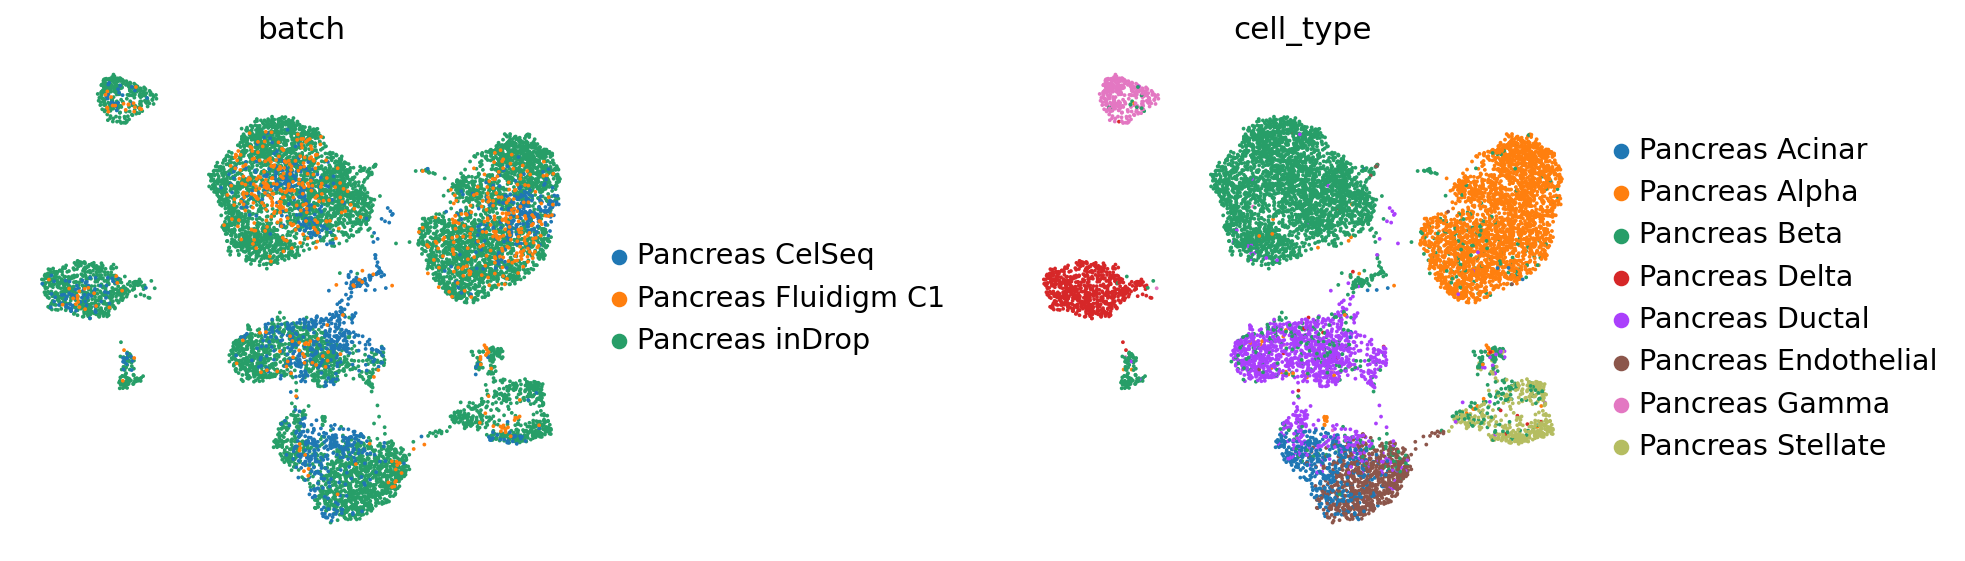

In [15]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [16]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

In [17]:
new_trvae = sca.models.TRVAE.load_query_data(adata=target_adata, learning_approach = 'Surgery', model=ref_path)


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [18]:
new_trvae.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0,
    learning_approach='Surgery',
)

Surgery is happening!
 |████----------------| 22.4%  - val_loss: 1091.5003662109 - val_recon_loss: 1080.8484619141 - val_kl_loss: 17.8268142700 - val_mmd_loss: 0.7580192566
ADJUSTED LR
 |█████---------------| 25.8%  - val_loss: 1083.3755493164 - val_recon_loss: 1071.2763671875 - val_kl_loss: 17.7149246216 - val_mmd_loss: 0.7616455078
ADJUSTED LR
 |█████---------------| 27.2%  - val_loss: 1113.8155517578 - val_recon_loss: 1100.9625000000 - val_kl_loss: 17.9286960602 - val_mmd_loss: 0.7511753082
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 114


In [19]:
adata_latent = sc.AnnData(new_trvae.get_latent())
adata_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

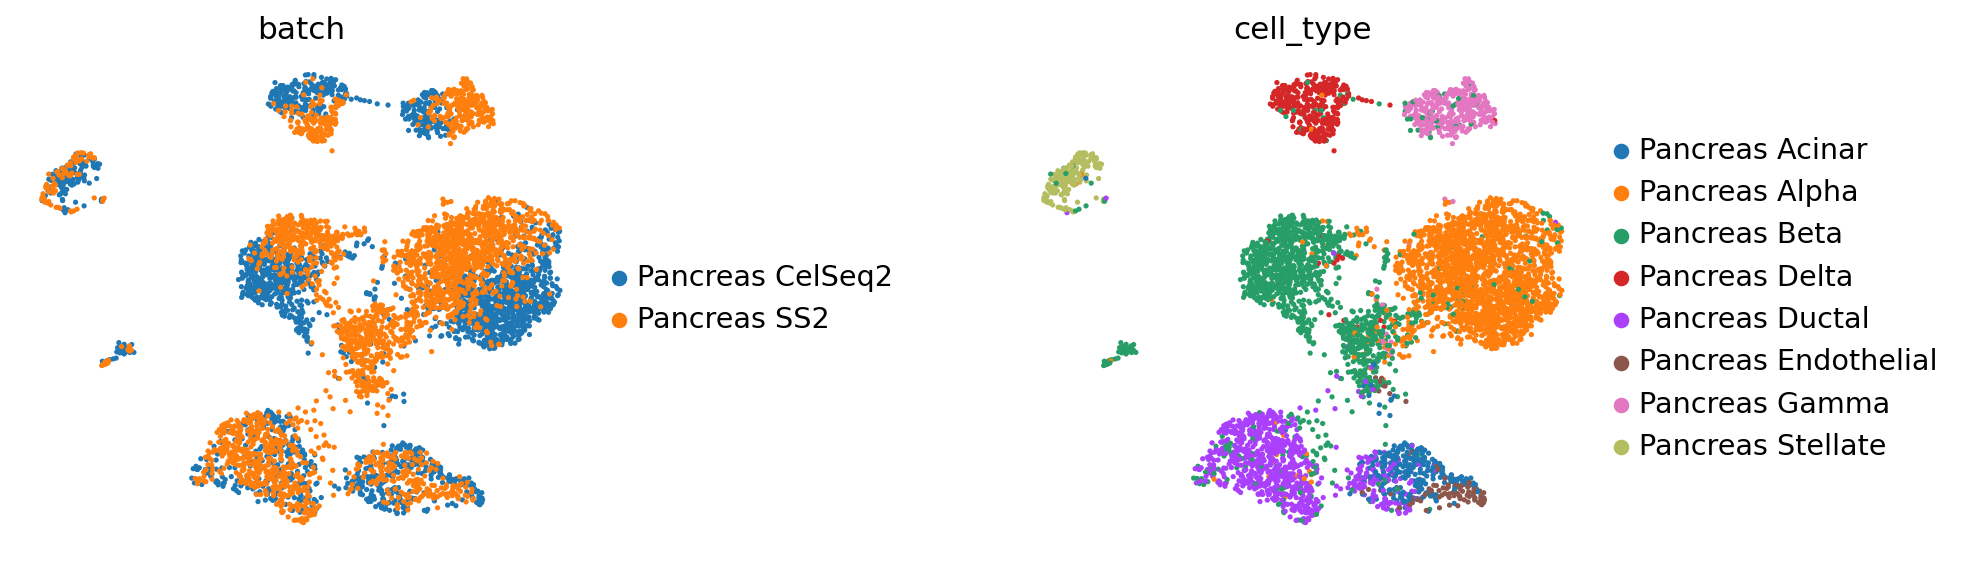

In [20]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [21]:
surg_path = 'surgery_model'
new_trvae.save(surg_path, overwrite=True)

In [22]:
full_latent = sc.AnnData(new_trvae.get_latent(adata.X, adata.obs[condition_key]))
full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()

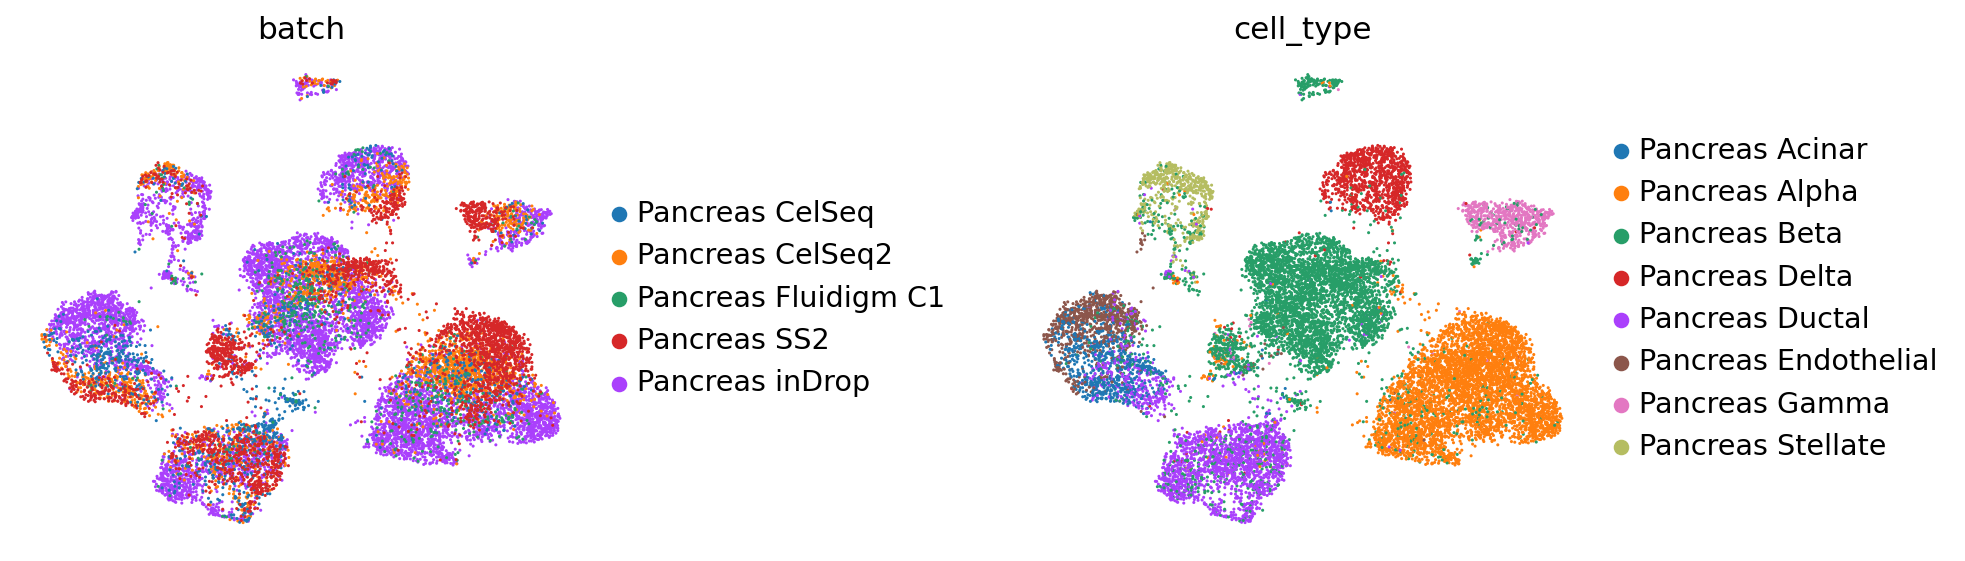

In [23]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [24]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:14:41


In [25]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_surgery=scib.metrics.graph_connectivity(full_latent, 'batch')
# Bio_cons_graph_conn_rehearsal=scib.metrics.graph_connectivity(full_latent, 'cell_type')

Batch_corr_graph_conn_surgery 

0.7608051257578508

In [26]:
sc.tl.umap(full_latent)
Batch_corr_ASW_surgery=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_surgery


mean silhouette per group:                       silhouette_score
group                                 
Pancreas Acinar               0.843554
Pancreas Alpha                0.861357
Pancreas Beta                 0.862464
Pancreas Delta                0.823930
Pancreas Ductal               0.823352
Pancreas Endothelial          0.795527
Pancreas Gamma                0.769898
Pancreas Stellate             0.799617


0.8224623662914746

In [27]:
Bio_cons_ASW_surgery=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_surgery

0.6725379973649979

In [28]:
isolated_labels_surgery=scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_surgery

isolated labels: no more than 5 batches per label


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Acinar: 0.6093845216331506


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Alpha: 0.9557917109458023


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Beta: 0.8404529655791008


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Delta: 0.9641125121241515


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Ductal: 0.8212983223924144


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Endothelial: 0.761071623838163


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Gamma: 0.9231927710843374


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Stellate: 0.8701923076923077


0.8431870919111784

In [29]:
pcr_surgery=scib.metrics.pcr_comparison(source_adata, adata, covariate='batch', embed=None, n_comps=50, scale=False, verbose=False)
pcr_surgery

0.028701497023668674

In [30]:
#                    'latent replay_1%': [],
#                    'latent replay_10%': [],
#                    'latent replay_50%': [],'Bio_cons_graph_conn'
#                    'latent replay_100%': [],

Batch_corr_graph_conn_surgery= 0.7608051257578508
Batch_corr_graph_conn_onetenth=0.9048741734427915
Batch_corr_graph_conn_onefourth= 0.899889876263836
Batch_corr_graph_conn_oneseven=0.900851122200876
Batch_corr_graph_conn_justone=0.907825266669773
Batch_corr_graph_conn_rehearsal= 0.8419137670991846
Batch_corr_graph_conn_LR_1= 0.9525413804706051
Batch_corr_graph_conn_LR_1_EWC_1= 0.8538528428288419
Batch_corr_graph_conn_std = 0.6525543008643219   

Batch_corr_ASW_surgery= 0.8224623662914746
Batch_corr_ASW_onetenth=0.7700163313882914
Batch_corr_ASW_onefourth= 0.7647092329403207
Batch_corr_ASW_oneseven=0.7677420977118364
Batch_corr_ASW_justone=0.7442970386211107
Batch_corr_ASW_rehearsal=0.8056815952195894
Batch_corr_ASW_LR_1= 0.6539111201049619
Batch_corr_ASW_LR_1_EWC_1= 0.7546766773118789
Batch_corr_ASW_std= 0.8286109488080287

Bio_cons_ASW_surgery= 0.6725379973649979
Bio_cons_ASW_onetenth=0.6302791982889175
Bio_cons_ASW_onefourth=0.6720504760742188
Bio_cons_ASW_oneseven=0.6242425590753555
Bio_cons_ASW_justone=  0.5981042683124542  #0.7442970386211107 
Bio_cons_ASW_rehearsal=0.6269718110561371
Bio_cons_ASW_LR_1= 0.5299279093742371 
Bio_cons_ASW_LR_1_EWC_1= 0.5416091568768024
Bio_cons_ASW_std= 0.6770734935998917

isolated_labels_surgery= 0.8431870919111784
isolated_labels_onetenth=0.8439304117951834
isolated_labels_onefourth=0.8283473352451141
isolated_labels_oneseven = 0.8430725908139767
isolated_labels_justone=   0.8423944609068901 #0.8312470266054668
isolated_labels_rehearsal=0.8334421194080218
isolated_labels_LR_1= 0.6812798420335051
isolated_labels_LR_1_EWC_1= 0.7180090584900156
isolated_labels_std= 0.8447661032386597

pcr_surgery = 0.028701497023668674
pcr_onetenth = 0.02870146673652502
pcr_onefourth=0.02870146673652502
pcr_oneseven = 0.02870146673652502 
pcr_justone = 0.02870146673652502
pcr_rehearsal = 0.02870146673652502
pcr_LR_1= 0.02870146673652502
pcr_LR_1_EWC_1= 0.02870146673652502
pcr_std = 0


import pandas as pd
methods_metrics = {'Surgery': [isolated_labels_surgery,Bio_cons_ASW_surgery,
                               Batch_corr_ASW_surgery, Batch_corr_graph_conn_surgery, pcr_surgery, 
                               (isolated_labels_surgery+Bio_cons_ASW_surgery+
                               Batch_corr_ASW_surgery+ Batch_corr_graph_conn_surgery+ pcr_surgery)/5], 
#                    'ewc_0.1': [isolated_labels_onetenth, Bio_cons_ASW_onetenth, 
#                                Batch_corr_ASW_onetenth, Batch_corr_graph_conn_onetenth,pcr_onetenth, 
#                                (isolated_labels_onetenth+ Bio_cons_ASW_onetenth+ 
#                                Batch_corr_ASW_onetenth+ Batch_corr_graph_conn_onetenth +pcr_onetenth)/5],
#                    'ewc_0.4': [isolated_labels_onefourth, Bio_cons_ASW_onefourth,
#                                Batch_corr_ASW_onefourth, Batch_corr_graph_conn_onefourth,pcr_onefourth, 
#                                (isolated_labels_onefourth+ Bio_cons_ASW_onefourth+
#                                Batch_corr_ASW_onefourth+ Batch_corr_graph_conn_onefourth+pcr_onefourth)/5], 
#                    'ewc_0.7':[isolated_labels_oneseven, Bio_cons_ASW_oneseven, 
#                               Batch_corr_ASW_oneseven, Batch_corr_graph_conn_oneseven, pcr_oneseven, 
#                               (isolated_labels_oneseven+ Bio_cons_ASW_oneseven+ 
#                               Batch_corr_ASW_oneseven+ Batch_corr_graph_conn_oneseven+ pcr_oneseven)/5],
                   'ewc_1': [isolated_labels_justone, Bio_cons_ASW_justone,
                               Batch_corr_ASW_justone, Batch_corr_graph_conn_justone, pcr_justone, 
                             (isolated_labels_justone+ Bio_cons_ASW_justone+
                               Batch_corr_ASW_justone+ Batch_corr_graph_conn_justone+ pcr_justone)/5], 
                   'rehearsal': [isolated_labels_rehearsal, Bio_cons_ASW_rehearsal, 
                               Batch_corr_ASW_rehearsal, Batch_corr_graph_conn_rehearsal, pcr_rehearsal,
                             (isolated_labels_rehearsal+ Bio_cons_ASW_rehearsal+ 
                               Batch_corr_ASW_rehearsal+ Batch_corr_graph_conn_rehearsal+ pcr_rehearsal)/5],
                  'Latent_replay_1.0':[isolated_labels_LR_1, Bio_cons_ASW_LR_1,
                               Batch_corr_ASW_LR_1, Batch_corr_graph_conn_LR_1, pcr_LR_1, 
                             (isolated_labels_LR_1+ Bio_cons_ASW_LR_1+
                               Batch_corr_ASW_LR_1+ Batch_corr_graph_conn_LR_1+ pcr_LR_1)/5],
                  'LR_1+EWC_1.0': [isolated_labels_LR_1_EWC_1, Bio_cons_ASW_LR_1_EWC_1, 
                               Batch_corr_ASW_LR_1_EWC_1, Batch_corr_graph_conn_LR_1_EWC_1, pcr_LR_1_EWC_1, 
                             (isolated_labels_LR_1_EWC_1+ Bio_cons_ASW_LR_1_EWC_1+ 
                               Batch_corr_ASW_LR_1_EWC_1+ Batch_corr_graph_conn_LR_1_EWC_1+ pcr_LR_1_EWC_1)/5],
                  'naive':[isolated_labels_std, Bio_cons_ASW_std, 
                               Batch_corr_ASW_std, Batch_corr_graph_conn_std, pcr_std, 
                             (isolated_labels_std+ Bio_cons_ASW_std+ 
                               Batch_corr_ASW_std+ Batch_corr_graph_conn_std+ pcr_std)/5]} 
index = ['isolated_labels','Bio_cons_ASW', 'Batch_corr_ASW','Batch_corr_graph_conn', 'pcr',  'overall'] #'approx_time_hrs',
methods_metrics_df = pd.DataFrame(data=methods_metrics, index=index)
methods_metrics_df

#time_LR_1_EWC_01,time_LR_1, time_rehearsal,time_justone,time_oneseven,time_onefourth,time_onetenth,time_surgery,

,Surgery,ewc_1,rehearsal,Latent_replay_1.0,LR_1+EWC_1.0,naive
isolated_labels,0.843187,0.842394,0.833442,0.681280,0.718009,0.844766
Bio_cons_ASW,0.672538,0.598104,0.626972,0.529928,0.541609,0.677073
Batch_corr_ASW,0.822462,0.744297,0.805682,0.653911,0.754677,0.828611
Batch_corr_graph_conn,0.760805,0.907825,0.841914,0.952541,0.853853,0.652554
pcr,0.028701,0.028701,0.028701,0.028701,0.028701,0.000000
overall,0.625539,0.624265,0.627342,0.569272,0.579370,0.600601


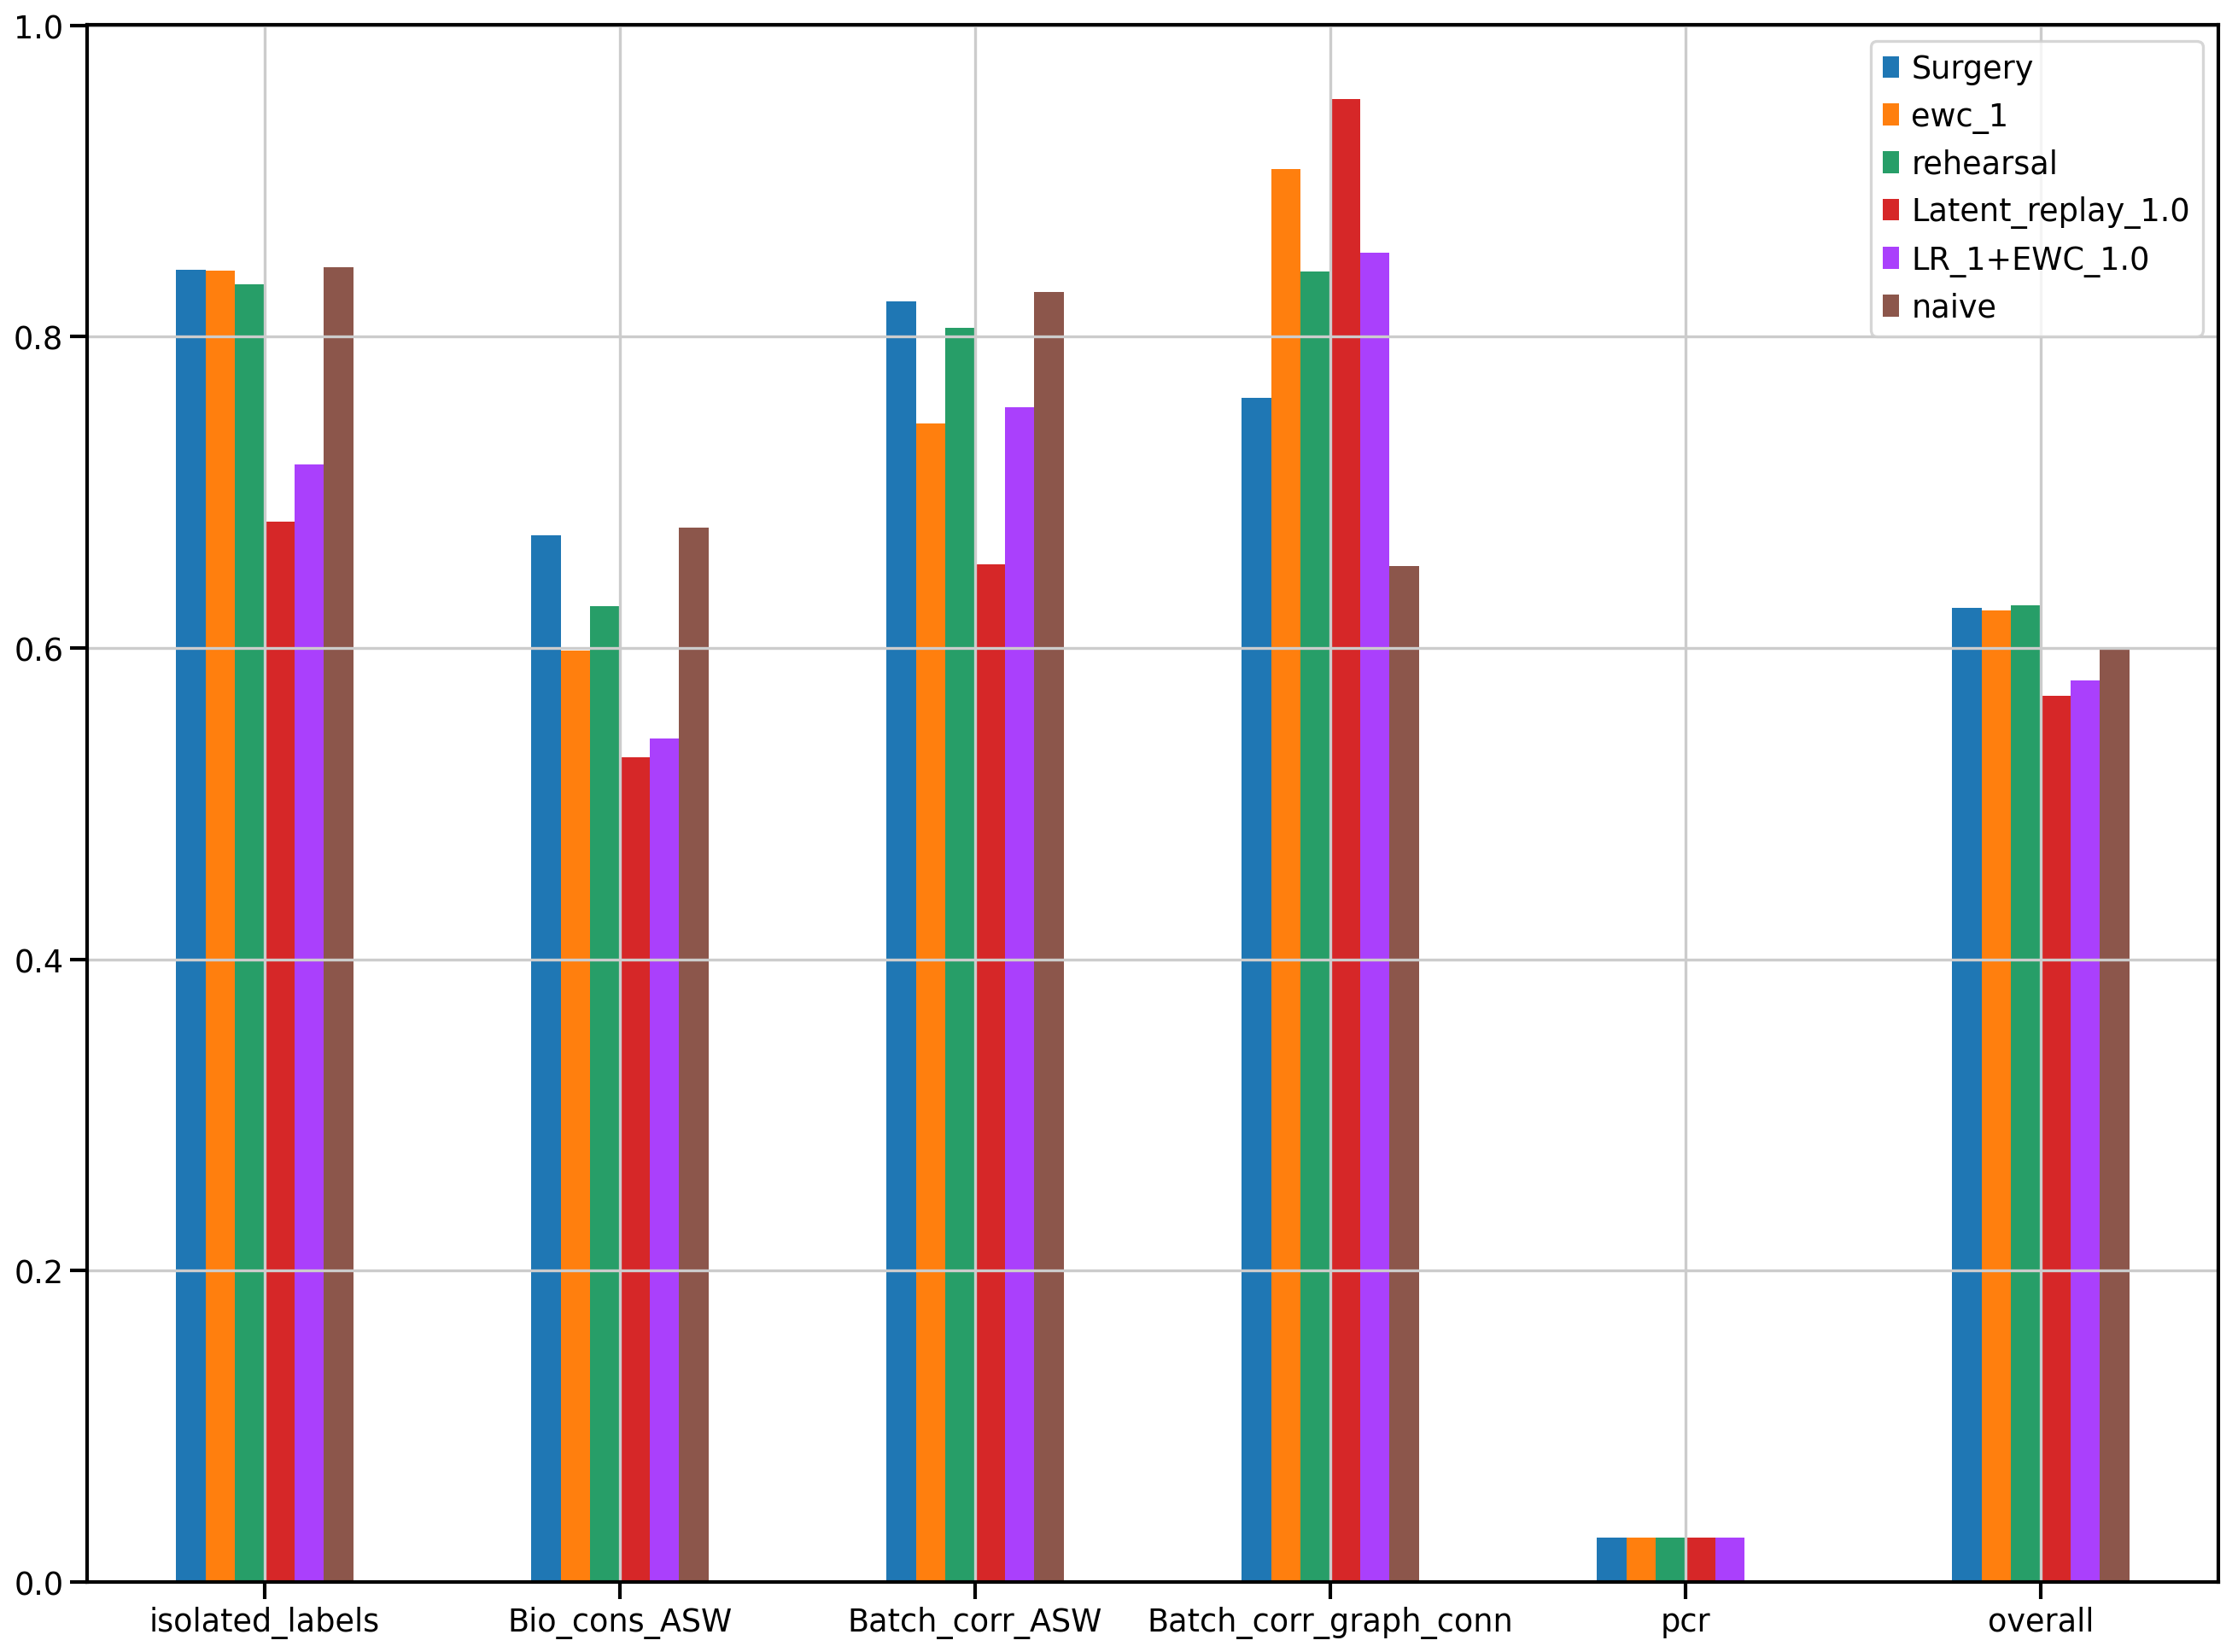

In [31]:
ax = methods_metrics_df.plot.bar(rot=0, figsize = (20,15))
# import matplotlib.pyplot as plt
# ax.axhline(y=1.5, color='r', linestyle='-')
# plt.show()

In [34]:
time_surgery = 0.2 #00;31;41
# time_onetenth = 1 #00;58;16
# time_onefourth = 0.65 #00;39;46
# time_oneseven = 0.65 #00:41:08
time_justone = 0.4 #00;45;57, 01:11:27
time_rehearsal = 0.25 #00;39;1
time_LR_1 = 1.2
time_LR_1_EWC_1 = 1.11
time_std = 0.5
methods_metrics = {'Surgery': [time_surgery], 
#                    'ewc_0.1': [time_onetenth],
#                    'ewc_0.4': [time_onefourth], 
#                    'ewc_0.7':[time_oneseven],
                   'ewc_1': [time_justone], 
                   'rehearsal': [time_rehearsal],
                  'Latent_replay_1.0':[time_LR_1],
                  'LR_10+EWC_1.0': [time_LR_1_EWC_1 ],
                  'naive': [time_std]} 
index = ['approx_time_hrs'] 
methods_metrics_df = pd.DataFrame(data=methods_metrics, index=index)
methods_metrics_df

,Surgery,ewc_1,rehearsal,Latent_replay_1.0,LR_10+EWC_1.0,naive
approx_time_hrs,0.2,0.4,0.25,1.2,1.11,0.5


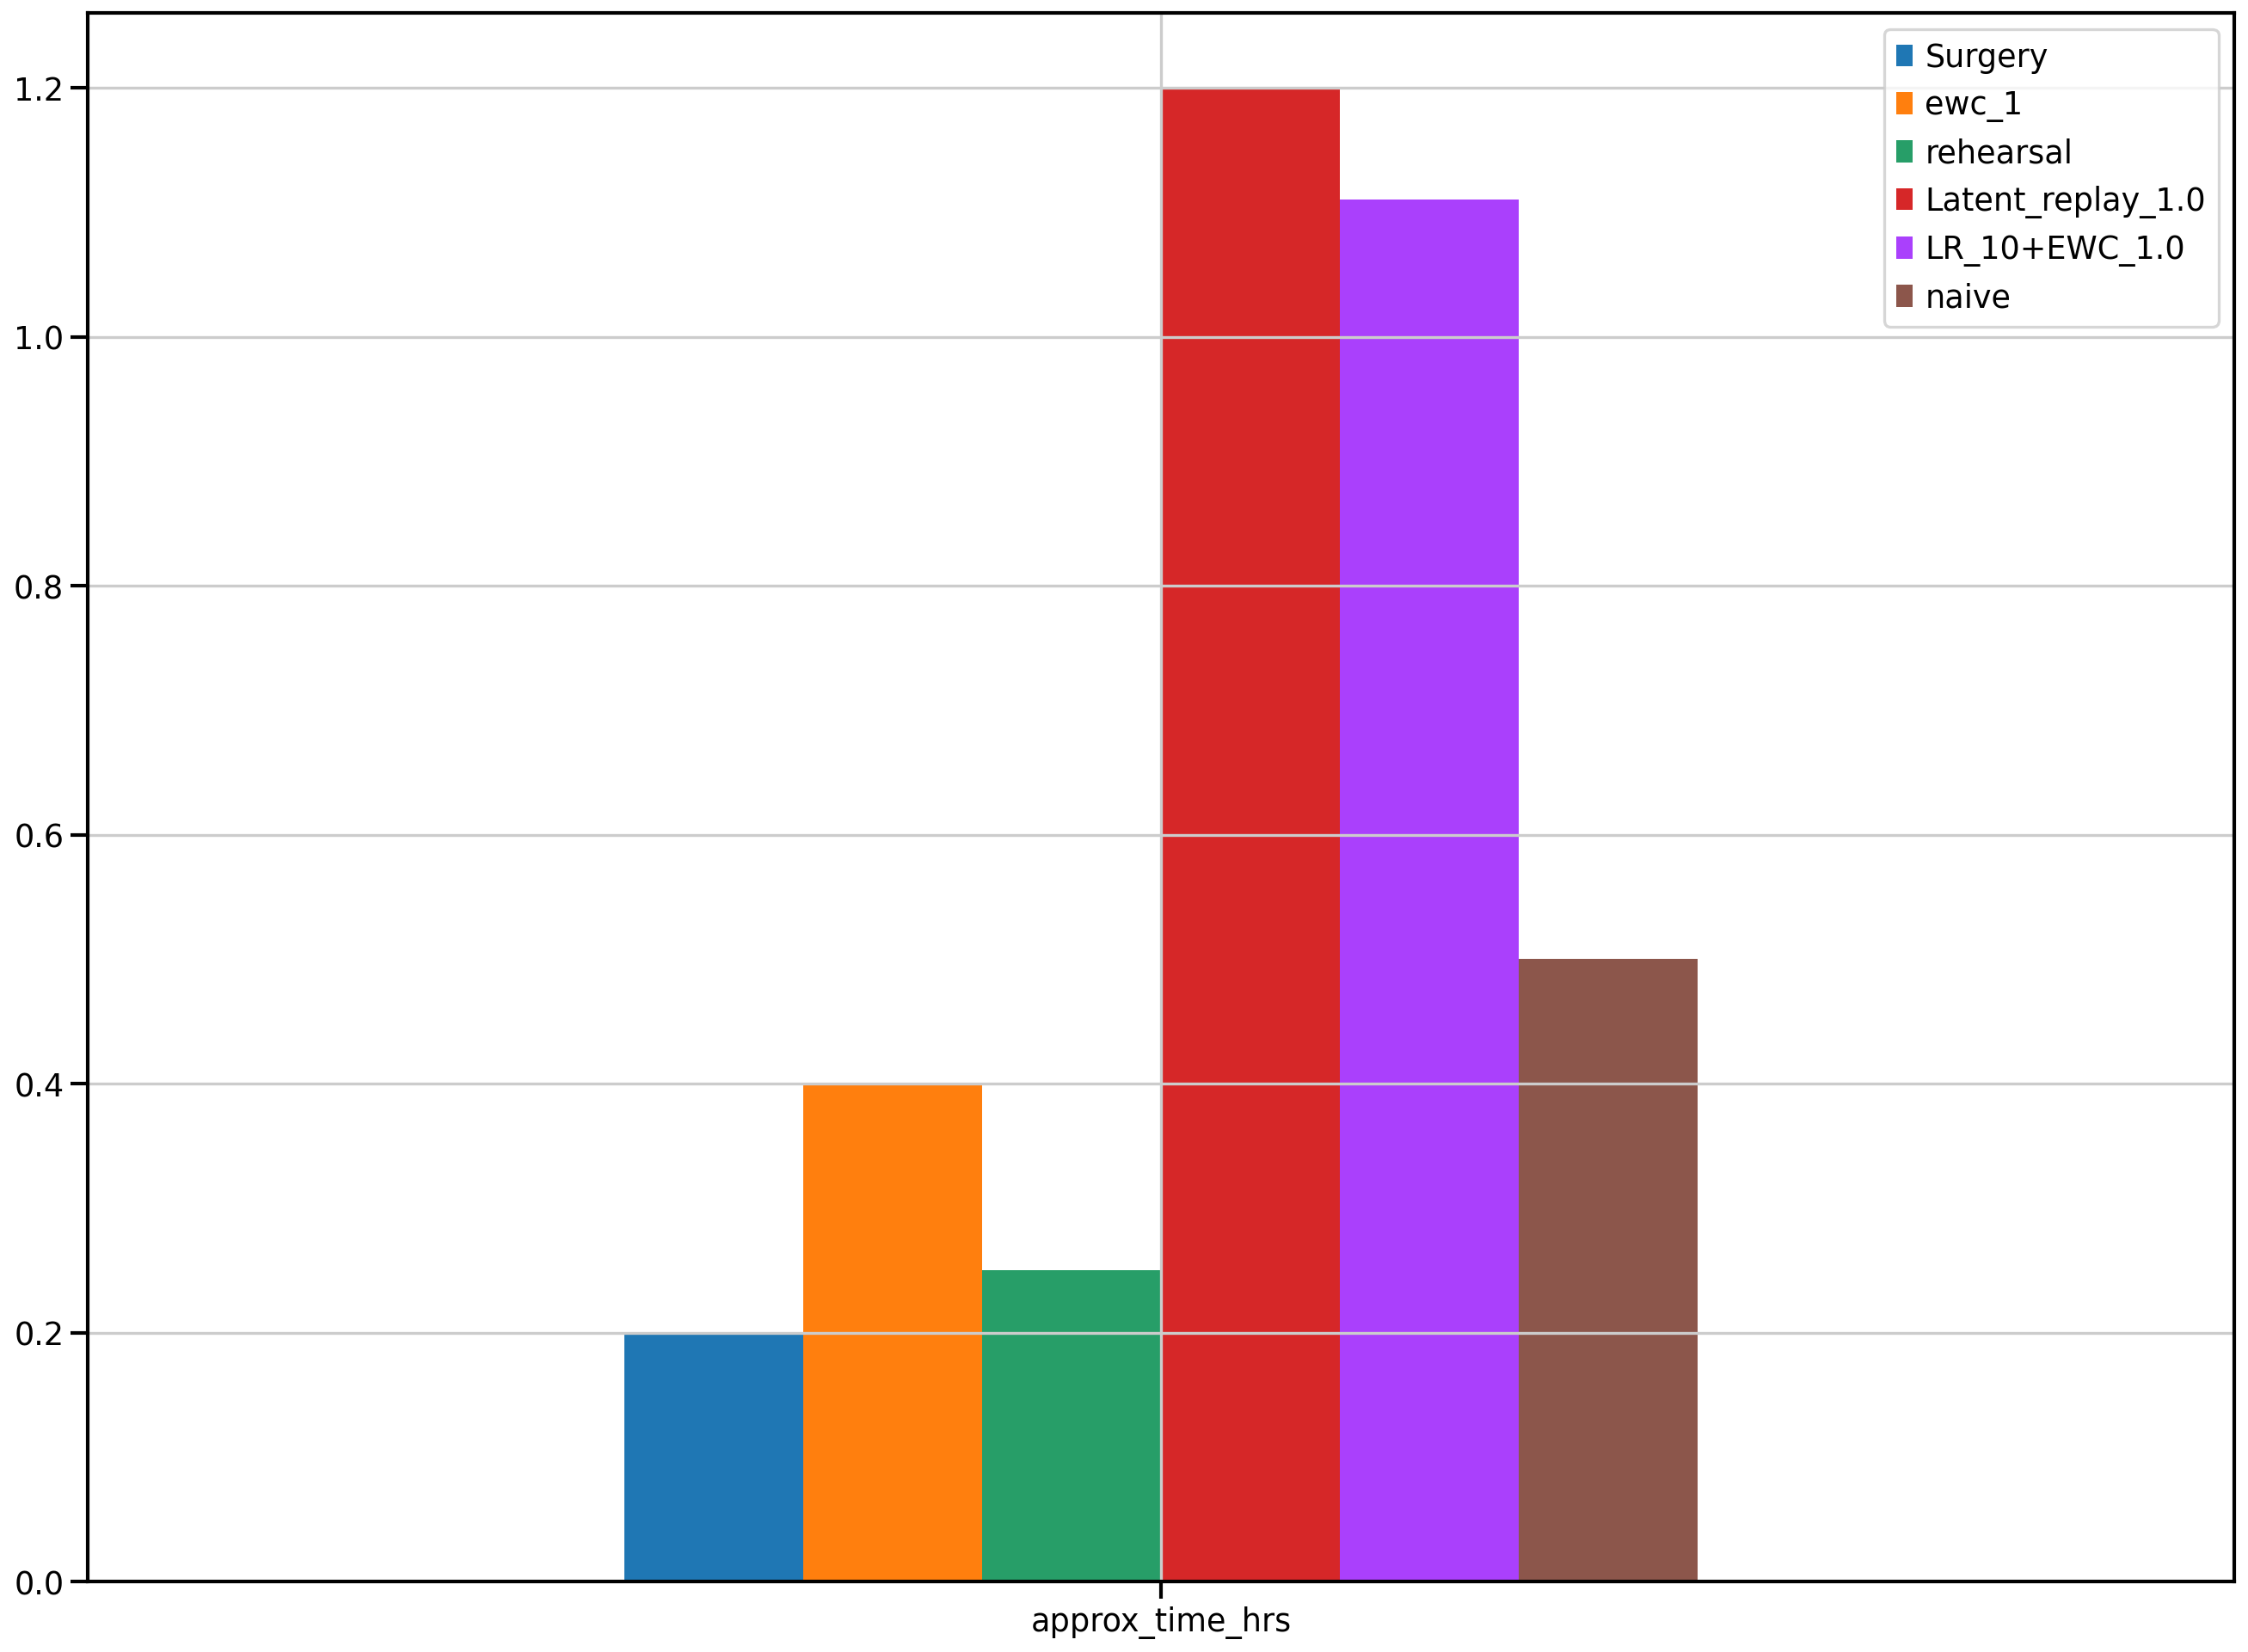

In [35]:
ax = methods_metrics_df.plot.bar(rot=0, figsize = (20,15))